# Objemové zamykání

## Formulace problému
Připomeňme vztah mezi $(\lambda, \mu)$ a $(E, \nu)$

$$
\lambda=\frac{E\nu}{(1+\nu)(1−2\nu)},\quad \mu=\frac{E}{2(1+\nu)}.
$$

Základní 2D formulace představená dříve je založena na tuhosti $E$, nicméně pro $\nu\rightarrow 0.5$ platí, že Youngův modul pružnosti $E\rightarrow\infty$ a tedy výpočet kolabuje pro parametry $\nu$ blízké 0.5. Tato singularita zapříčiňuje tzv. objemové zamykání, které může být viditelné z následujícího jednoduchého numerického experimentu. Představme si čtvercovou výpočetní doménu, ve spodní části upevněnou, které je zatěžována na horní hraně. Navíc předpokládejme téměř kritickou hodnotu Poissonova čísla $\nu=0.4999$.

Odezva takové domény by měla být symetrická. Nicméně posuďte výsledek sami...

In [5]:
import dolfinx as dfx
from mpi4py import MPI
import ufl
import numpy as np
from petsc4py.PETSc import ScalarType
import matplotlib.pyplot as plt
import dolfinx.fem.petsc

# -------------------------
# Parameters
# -------------------------
# Geometry paramaters
l_x, l_y = 1.0, 1.0  # Width, Height

# Number of elements
nx, ny = 10, 10

# Degree orders
deg = 1  # Order of elements

# Material parameters
E, nu = 210e9, 0.49999  # Young's module, Poisson ratio
mu, lmbda = 0.5 * E / (1 + nu), E * nu / (1 + nu) / (1 - 2 * nu)  # Lame's coefficients

# --------------------
# Define geometry
# --------------------
mesh = dfx.mesh.create_rectangle(MPI.COMM_WORLD, [[0.0, 0.0], [l_x, l_y]], [nx, ny])
tdim = mesh.topology.dim
fdim = tdim - 1

# -------------------------
# Function space
# -------------------------
# Main space for displacement field
v = dfx.fem.FunctionSpace(mesh, ("P", 1, (2,)))

# Displacement functions
u_tr = ufl.TrialFunction(v)
u_test = ufl.TestFunction(v)
x_sol = dfx.fem.Function(v)

# -------------------------
# Geometry parts
# -------------------------
def left(x):
    return np.isclose(x[0], 0.0)

def right(x):
    return np.isclose(x[0], l_x)

def bottom(x):
    return np.isclose(x[1], 0.0)

def top(x):
    return np.isclose(x[1], l_y)

# -------------------------
# Boundary conditions
# -------------------------
def dirichletbc_subspace(subspace, location, value_i):
    v_i, submap_i = subspace.collapse()
    dofs = dfx.fem.locate_dofs_geometrical((subspace, v_i), location)
    return dfx.fem.dirichletbc(ScalarType(value_i), dofs[0], subspace)

bc1 = dirichletbc_subspace(v.sub(0), bottom, 0.0)
bc2 = dirichletbc_subspace(v.sub(1), bottom, 0.0)
bc3 = dirichletbc_subspace(v.sub(1), top, -0.5)
bc = [bc1, bc2, bc3]

# -------------------------
# Weak form
# -------------------------
# Elastic stress tensor
def sigma(u_i):
    return lmbda * (ufl.tr(eps(u_i))) * ufl.Identity(2) + 2.0 * mu * (eps(u_i))

# Elastic strain tensor
def eps(v_i):
    return ufl.sym(ufl.grad(v_i))

f = dfx.fem.Constant(mesh, np.array([0.0, 0.0]))
a = ufl.inner(sigma(u_tr), eps(u_test))*ufl.dx
L = ufl.inner(f, u_test) * ufl.dx

# -------------------------
# Solution
# -------------------------
u_sol = dfx.fem.Function(v)

problem = dfx.fem.petsc.LinearProblem(
    a, L, u=u_sol, bcs=bc, petsc_options={"ksp_type": "preonly", "pc_type": "lu"}
)
problem.solve()

vtk = dfx.io.VTKFile(mesh.comm, "linear_elasticity.pvd", "w")
vtk.write_function(u_sol, 0)
vtk.close()

In [6]:
from dolfinx import plot
import pyvista

pyvista.start_xvfb()

DRI3 not available
failed to load driver: zink


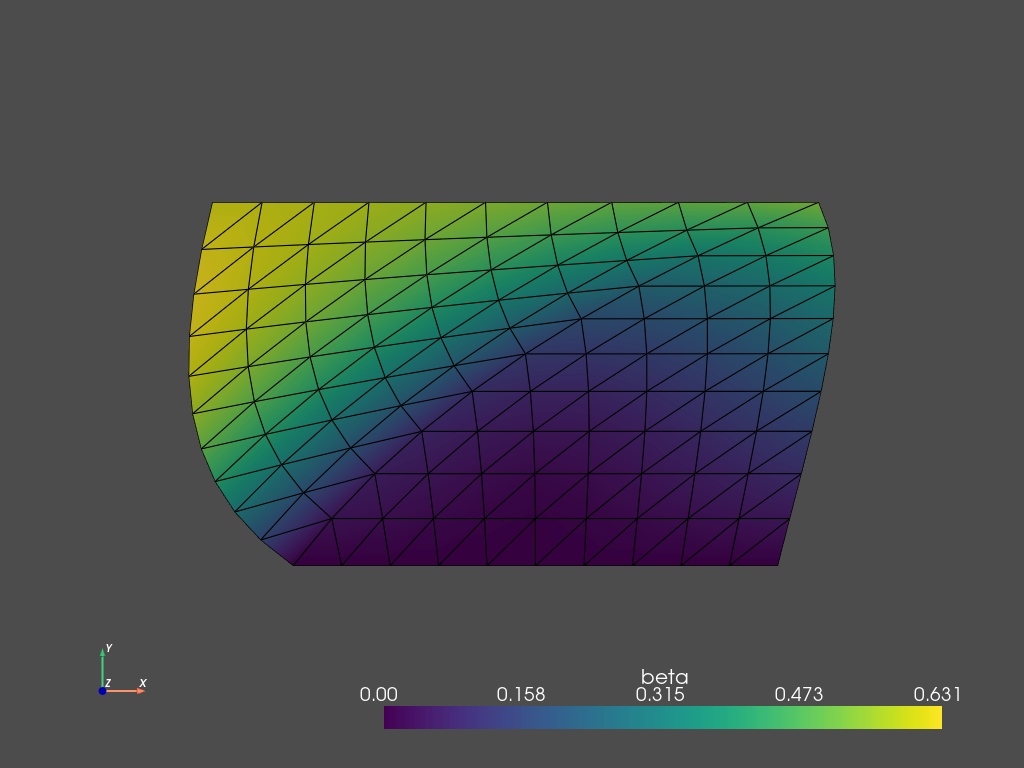

In [7]:
# Create plotter and pyvista grid
p = pyvista.Plotter()
topology, cell_types, geometry = plot.vtk_mesh(v)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

beta_3D = np.zeros((geometry.shape[0], 3))
#beta_3D[:, :2] = u_sol.x.array.reshape(-1, 2) @ np.array([[0, -1], [1, 0]])
beta_3D[:, :2] = u_sol.x.array.reshape(-1, 2)
grid["beta"] = beta_3D
grid.set_active_vectors("beta")

# Attach vector values to grid and warp grid by vector
#grid["u"] = u_sol.x.array.reshape((geometry.shape[0], 2))
#actor_0 = p.add_mesh(grid, style="wireframe", color="k")
warped = grid.warp_by_vector("beta", factor=0.5)
actor_1 = p.add_mesh(warped, show_edges=True)
p.show_axes()
p.view_xy()
if not pyvista.OFF_SCREEN:
    p.show(jupyter_backend="trame")
else:
    figure_as_array = p.screenshot("deflection.png")

Pro fyzikálně správnou odezvu přepněme do smíšeného režimu, kdy budeme počítat nejen pole posunů, ale i pole napětí. V předchozím příkladu jsme uvažovali tenzor napětí jako 

$$
\sigma=\lambda\mathrm{div}(u)\mathrm{I}+2\mu\varepsilon(u),
$$

kde $u$ bylo hledané neznámé pole. Nyní definujeme hydrostatický tlak $p=-\lambda\mathrm{div}u$ jako další neznámé pole. Tedy předchozí silná forma

$$
[TODO]
$$

je nahrazena soustavou rovnic

$$
[TODO]
$$

Příslušná slabá forma je

$$
[TODO]
$$

Jedná se o příklad Hellinger-Reissnerovi smíšené formulace kde existence řešení je zajištěna např. inf-sup Ladyzhenskaya-Babuška-Brezzi podmínkou (https://en.wikipedia.org/wiki/Ladyzhenskaya%E2%80%93Babu%C5%A1ka%E2%80%93Brezzi_condition).